# Neural Quest Assignment-3
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [27]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os
import random
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

# check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("working on",device)

working on cpu


## Load *Dataset*
Use the [pickle file](https://drive.google.com/file/d/1W4T7PdA2lJ3XLAOckKOs7lPnuDhS2Jez/view?usp=sharing) shared for this assignment here.

In [28]:
# mount Google Drive to access the dataset
from sklearn import preprocessing
# load the data set
file = 'train_cifar.pkl'
with open(file,'rb') as data:
    training_data = pickle.load(data)

X = training_data['X']
y = training_data['y']

# normalize
# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 1)
(10000, 1)


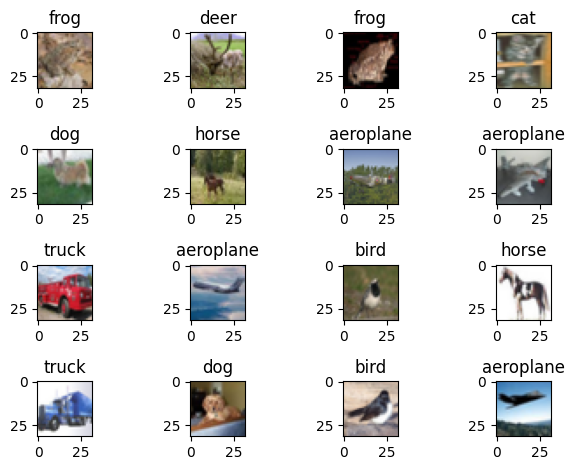

In [29]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
classes = ['aeroplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
size=X.shape[0]
for i in range(16):
    plt.subplot(4,4,i+1)
    j = np.random.randint(size)
    plt.imshow(X[j])
    plt.title(classes[y[j][0]])
plt.tight_layout()

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

You will have to perform normalization, augmentation on the dataset here itself, have a look at [PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html).

**Note -** While initializing the dataset class object, make sure you only pass the numpy arrays for images and labels. So the ```__init__``` function should look like
```
    def __init__(self, X, y):
```

In [30]:
# define your dataset class
class CIFAR_Dataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.from_numpy(X.transpose([0, 3, 1, 2])).float()
    self.y = torch.from_numpy(y)
    self.transform = transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5))

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return [self.transform(self.X[idx]), self.y[idx]]

train_dataset = CIFAR_Dataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 3)
test_dataset = CIFAR_Dataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = False, num_workers = 3)
total_dataset = CIFAR_Dataset(X, y)
totalloader = torch.utils.data.DataLoader(total_dataset, batch_size = 4, shuffle = True, num_workers = 3)
print(len(trainloader))
print(len(testloader))
print(len(totalloader))

10000
2500
12500


## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [31]:
# define a child class of nn.Module for your model
# specify the architecture here itself
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [33]:
def train(net, optimizer, criterion, trainloader):
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            labels = labels.view(-1) 
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

In [34]:
train(net, optimizer, criterion, trainloader)

[1,  2000] loss: 2.172
[1,  4000] loss: 1.803
[1,  6000] loss: 1.634
[1,  8000] loss: 1.555
[1, 10000] loss: 1.502
[2,  2000] loss: 1.413
[2,  4000] loss: 1.390
[2,  6000] loss: 1.369
[2,  8000] loss: 1.356
[2, 10000] loss: 1.306
Finished Training


## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [23]:
def init_weights():
    pass

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [35]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(correct)
print(total)
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

8259
10000
Accuracy of the network on the 10000 test images: 82 %


## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file ```dataset.py``` with the dataset class and all necessary imports. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py```, ```dataset.py``` class files and the ```ass_2.pt``` model-weights file to the repository.

In [36]:
# from google.colab import files
final_model = net
torch.save(final_model, 'ass_2.pt')
# files.download('ass_2.pt') # download the file from the Colab session for submission

Check if it got saved right!

In [37]:
# load the model, use predict function
model = torch.load('ass_2.pt')
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in totalloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(correct)
print(total)
print(f'Accuracy of the network on the 50000 total images: {100 * correct // total} %')

42357
50000
Accuracy of the network on the 50000 total images: 84 %
